In [1]:
from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import glob

import tensorflow as tf
import numpy as np
import scipy.misc

import tensorflow.contrib.slim as slim
from tensorflow.python.tools import freeze_graph
import os


In [26]:
def transform(image, resize_height=64, resize_width=64):
    if resize_height or resize_width:
        resizedImage = scipy.misc.imresize(image, [resize_height, resize_width])
    else:
        resizedImage = image
    return np.array(resizedImage)/127.5 - 1.

def get_image(image_path, resize_height=64, resize_width=64):
    image = scipy.misc.imread(image_path).astype(np.float)
    return transform(image, resize_height, resize_width)

def get_images(image_paths, resize_height=64, resize_width=64):
    return [get_image(p, resize_height, resize_width) for p in image_paths]

In [3]:
def showarray(a, transform='tanh', fmt='jpeg'):
    if transform == 'tanh':
        a = np.uint8(((a+1)/2)*255)
    else:
        a = np.uint8(np.clip(a, 0, 1)*255)

    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [97]:
def buildMinibatchDiscriminator(features, numFeatures, kernels, kernelDim=5, reuse=False):
    with tf.variable_scope("minibatch") as scope:
        if reuse:
            scope.reuse_variables()
        # TODO: no undefined dimensions until 1.0 release
        batchTensor = tf.get_variable('disc_minibatch',
                       shape=[numFeatures, kernels, kernelDim],
                       initializer=tf.truncated_normal_initializer(stddev=0.1),
                       regularizer=slim.l2_regularizer(0.05))
        
        flatFeatures = tf.reshape(features, (16,-1))
        multFeatures = tf.einsum('ij,jkl->ikl',flatFeatures, batchTensor)
        multFeaturesExpanded1 = tf.expand_dims(multFeatures,[1])

        fn = lambda x: x - multFeatures

        multFeaturesDiff = tf.exp(
            -tf.reduce_sum(
                tf.abs(
                    tf.map_fn(fn, multFeaturesExpanded1)
                ),
            axis=[3])
        )

        output = tf.reduce_sum(multFeaturesDiff, axis=[1]) - 1
    
    return output

# Network building
def buildBatchL1(layer):
    layerMean = tf.reduce_mean(layer, axis=[0])
    layerBatchL1 = tf.reduce_mean(tf.abs(layer - layerMean))
    
    return layerBatchL1

def buildDiscriminator(images, kernel_size=[3,3], reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
        # Convolutional discriminator
        discConv1 = slim.conv2d(images, 96, kernel_size,  stride=2, scope='disc_conv_1')
        discConv2 = slim.conv2d(discConv1, 96, kernel_size,  stride=2, normalizer_fn=slim.batch_norm, scope='disc_conv_2')
        discConv3 = slim.conv2d(discConv2, 64, kernel_size,  stride=2, normalizer_fn=slim.batch_norm, scope='disc_conv_3')
        discConv4 = slim.conv2d(discConv3, 64, kernel_size,  stride=2, normalizer_fn=slim.batch_norm, scope='disc_conv_4')
        
        numFeatures = height/16*width/16*64
        miniBatchDisc = buildMinibatchDiscriminator(discConv4, numFeatures, kernels=100, reuse=reuse)
        
        miniBatchSummary = slim.fully_connected(miniBatchDisc, 1, activation_fn = None, scope='disc_full_mini')
        
        # convBottleNeck = slim.flatten(discConv4, scope='bottleneck_flatten')
        convBottleNeck = tf.reshape(discConv4, (16, 1024))
        convSummary = slim.fully_connected(convBottleNeck, 1, activation_fn = None, scope='disc_full_conv')

        discriminatorBottleneck = tf.concat([convSummary, miniBatchSummary], 1)
        
        discriminator_logits = slim.fully_connected(discriminatorBottleneck, 1, activation_fn = None, scope='disc_full_final')
        discriminator = tf.nn.sigmoid(discriminator_logits)
        
        discriminatorLayers = [
            discriminator,
            discriminator_logits,
            discriminatorBottleneck,
            convSummary,
            convBottleNeck,
            miniBatchSummary,
            miniBatchDisc,
            discConv4,
            discConv3,
            discConv2,
            discConv1,
        ]
    return discriminatorLayers

def buildGenerator(embeddings, kernel_size=[3,3], reuse=False):
    with tf.variable_scope("generator") as scope:
        if reuse:
            scope.reuse_variables()
            
        # Reshape embeddings       
        generatorLinear = slim.fully_connected(embeddings, finalConvFilterLayers, activation_fn = None, scope='gen_linear')
        generatorReshape = tf.reshape(generatorLinear, [-1, finalHeight, finalWidth, dim*8])
        
        generatorConv1_1 = slim.conv2d(generatorReshape, 64, kernel_size,  
                                               stride=1, activation_fn=tf.nn.elu, normalizer_fn=slim.batch_norm, scope='gen_conv_1_1')
        
        generatorResize1 = tf.image.resize_images(generatorConv1_1, size=(finalHeight*2, finalWidth*2), method=1 )
        generatorConv2_1 = slim.conv2d(generatorResize1, 64, kernel_size,  
                                               stride=1, activation_fn=tf.nn.elu, normalizer_fn=slim.batch_norm, scope='gen_conv_2_1')
        generatorConv2_2 = slim.conv2d(generatorConv2_1, 32, kernel_size,  
                                               stride=1, activation_fn=tf.nn.elu, normalizer_fn=slim.batch_norm, scope='gen_conv_2_2')
        
        generatorResize2 = tf.image.resize_images(generatorConv2_2, size=(finalHeight*4, finalWidth*4), method=1 )
        generatorConv3_1 = slim.conv2d(generatorResize2, 32, kernel_size,  
                                               stride=1, activation_fn=tf.nn.elu, normalizer_fn=slim.batch_norm, scope='gen_conv_3_1')
        generatorConv3_2 = slim.conv2d(generatorConv3_1, 16, kernel_size,  
                                               stride=1, activation_fn=tf.nn.elu, normalizer_fn=slim.batch_norm, scope='gen_conv_3_2')
        
        generatorResize3 = tf.image.resize_images(generatorConv3_2, size=(finalHeight*8, finalWidth*8), method=1 )
        generatorConv4_1 = slim.conv2d(generatorResize3, 8, kernel_size,  stride=1,
                                          activation_fn=None, scope='gen_conv_4_1')
        
        generatorResize4 = tf.image.resize_images(generatorConv4_1, size=(finalHeight*16, finalWidth*16), method=1 )
        generatorConv5_1 = slim.conv2d(generatorResize4, channels, kernel_size,  stride=1,
                                          activation_fn=None, scope='gen_conv_5_1')

        generatorOut = tf.tanh(generatorConv5_1)
        
        generatorLayers = [
            generatorOut,
            generatorConv5_1,
            generatorResize4,
            generatorConv4_1,
            generatorResize3,
            generatorConv3_2,
            generatorConv3_1,
            generatorResize2,
            generatorConv2_2,
            generatorConv2_1,
            generatorResize1,
            generatorConv1_1,
            generatorReshape,
            generatorLinear,
        ]
        
        return generatorLayers
        
def buildModel(images, embeddings):
    
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):

        discRealLayers  = buildDiscriminator(images, reuse=False)
        generatorLayers = buildGenerator(embeddings, reuse=False)
        discFakeLayers  = buildDiscriminator(generatorLayers[0], reuse=True)

    return  discRealLayers, discFakeLayers, generatorLayers

In [98]:
batch_size = 16

height = 64
width = 64
channels = 3

dim = 16;

finalWidth = np.int_(width/16)
finalHeight = np.int(height/16)
finalConvFilterLayers = np.int(finalHeight*finalWidth*(dim*8))

imageDims = [height, width, channels]
embedDims = [100]

In [99]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

images     = tf.placeholder(tf.float32, [None] + [None, None, 3], name='images')
embeddings = tf.placeholder(tf.float32, [None] + embedDims, name='embeddings')

tf.add_to_collection("images", images)
tf.add_to_collection("embeddings", embeddings)

discRealLayers, discFakeLayers, generatorLayers = buildModel(images, embeddings)
discRealLogits = discRealLayers[1]
discFakeLogits = discFakeLayers[1]
generator = generatorLayers[0]

fakeMiniBatchDisc = discFakeLayers[2]
realMiniBatchDisc = discRealLayers[2]

# discriminator and generator losses
discLossesReal = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discRealLogits, labels=tf.ones_like(discRealLogits))
discRealTotal = tf.reduce_mean(discLossesReal)

discLossesFake = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discFakeLogits, labels=tf.zeros_like(discFakeLogits))
discFakeTotal = tf.reduce_mean(discLossesFake)

genLoss = tf.reduce_mean(
  tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discFakeLogits, labels=tf.ones_like(discFakeLogits)))

discLoss = discRealTotal + discFakeTotal

# need to optimize disc and gen only with respect to their parameters
variables = tf.trainable_variables()
discVars = [var for var in variables if 'disc_' in var.name]
genVars  = [var for var in variables if 'gen_' in var.name]

beta1 = 0.5

learning_rate = tf.placeholder(tf.float32, shape=[])

# create training ops on loss
dOptim = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
          .minimize(discLoss, var_list=discVars)

gOptim = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
          .minimize(genLoss, var_list=genVars)

init = tf.global_variables_initializer()
sess.run(init)

In [25]:
import glob
imageFileNames = glob.glob("/home/ubuntu/data/images_full/*.png")

In [41]:
fullImages = get_images(imageFileNames, resize_height=256, resize_width=256)

In [55]:
num_images = len(fullImage)

def getCrops(batchSize, cropHeight=64, cropWidth=64):
    # image is height x width x channels
    imageHeight, imageWidth, channels = fullImages[0].shape
    
    imageY = np.floor(
            np.multiply(
                np.random.rand(batchSize),(imageHeight - cropHeight)
            )
        ).astype('int')
    imageX = np.floor(
            np.multiply(
                np.random.rand(batchSize),(imageWidth - cropWidth)
            )
    ).astype('int')
    
    select = np.floor(np.random.rand(batch_size)*num_images).astype('int')
    
    return [fullImages[r][y:(y+cropHeight), x:(x+cropWidth),:] for (x, y, r) in zip(imageX, imageY, select)]

def getEmbeds(batchSize, embedLength):
    return np.random.rand(batchSize, embedLength)

In [ ]:
numEpochs = 1
numBatchPerEpoch = 100000
printIter = 25
l1LossWeight = 1
gdLearnRate = .001

for iter in range(numEpochs):
    
    for jter in range(numBatchPerEpoch):

        # update discriminator and generator
        for kter in range(1):
            x_embed = np.random.rand(16, embedDims[0])
            x_image = getCrops(16, cropHeight=height, cropWidth=width)
            sess.run([gOptim, dOptim],
                feed_dict={images: x_image, embeddings: x_embed, learning_rate: gdLearnRate})
        
        for kter in range(2):
            # update generator 2x because discriminator sees more examples (fake + real)
            x_embed = np.random.rand(16, embedDims[0])
            sess.run(gOptim,
                feed_dict={embeddings: x_embed, learning_rate: gdLearnRate})
    
        if jter%printIter == 0: 
            x_image = getCrops(16, cropHeight=height, cropWidth=width)
            x_embed = np.random.rand(16, embedDims[0])
            currentDiscLoss, currentReal, currentFake, currentGenLoss, currentFakeMini, currentRealMini = sess.run(
                [discLoss, discLossesReal, discLossesFake, genLoss, fakeMiniBatchDisc, realMiniBatchDisc], 
                feed_dict={images: x_image, embeddings: x_embed})
            clear_output()
            print(
                'jter: ', jter, ',',
                'Discriminator loss: ', currentDiscLoss, ',', '\n',
                'Generator loss: ', currentGenLoss, ',', '\n',
                'Minibatch Fake: ', np.mean(currentFakeMini,0) , ',','\n',
                'Minibatch Real: ', np.mean(currentRealMini,0))

jter:  375 , Discriminator loss:  1.59869 , 
 Generator loss:  0.395235 , 
 Minibatch Fake:  [ 14.74782372   6.04338551] , 
 Minibatch Real:  [ 15.3705883    5.47294426]


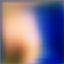

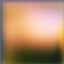

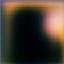

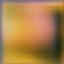

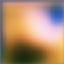

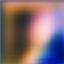

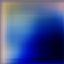

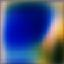

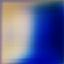

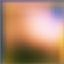

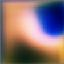

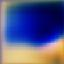

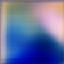

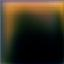

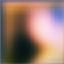

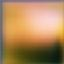

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(16, 4, 4, 64)


In [104]:
x_embed = np.random.rand(16, embedDims[0])
# x_embed = 0.5*np.ones((1, embedDims[0]))
# x_embed[0,20000:30000] = 1

samples, layerSamples = sess.run((generator, generatorLayers[-3]), feed_dict={embeddings: x_embed})
#samples = getCrops(16, cropHeight=height, cropWidth=width)

for sample in samples:
    showarray(sample)

print(np.sum(layerSamples == 0, axis=(1,2,3)))
print(layerSamples.shape)

In [34]:
# Freeze model
checkpoint_prefix = "./"
checkpoint_state_name = "my-model"
input_graph_name = "my-model.pb"
output_graph_name = "frozen-model.pb"
input_graph_path = os.path.join("./", "my-model.pb")
input_saver_def_path = ""
input_binary = False
output_node_names = 'discriminator/disc_conv_4/convolution'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_graph_path = os.path.join("./", output_graph_name)
clear_devices = False

# We save out the graph to disk, and then call the const conversion
# routine.
tf.train.write_graph(sess.graph_def, "./", "my-model.pb", True) #proto
saver = tf.train.Saver(tf.global_variables())
checkpoint_path = saver.save(sess,"./my-model.data")

freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_graph_path, clear_devices, "")

In [65]:
scores = sess.run(discLossesReal, feed_dict={images: x_image})
print(scores, np.mean(scores))
scores = sess.run(discLossesFake, feed_dict={embeddings: x_embed})
print(scores, np.mean(scores))

[[  2.01302782e-06]
 [  1.74654076e-06]
 [  2.75998580e-04]
 [  1.82114109e-05]
 [  6.19580896e-06]
 [  3.02006247e-05]
 [  3.20706546e-04]
 [  3.06647067e-04]
 [  1.45609709e-04]
 [  8.61895842e-06]
 [  1.71568336e-05]
 [  3.46408633e-05]
 [  1.05657164e-04]
 [  3.70653179e-05]
 [  8.27882650e-06]
 [  1.43511907e-05]] 8.33187e-05
[[  1.94667721e+00]
 [  1.43256426e+00]
 [  4.02907637e-04]
 [  8.35512340e-01]
 [  2.10230276e-01]
 [  1.07395481e-05]
 [  1.75760388e+00]
 [  4.50042295e+00]
 [  2.36718846e-03]
 [  2.88805403e-02]
 [  3.72046083e-02]
 [  1.22876399e-05]
 [  1.83857039e-01]
 [  1.79373637e-06]
 [  1.41834879e+00]
 [  3.22605586e+00]] 0.97376


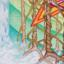

In [52]:
showarray(x_image[15])